<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Обучение модели классификации комментариев

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В моем распоряжении набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 


**Описание данных**

Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Выгрузка требуемых библиотек.

In [26]:
!pip install imblearn -q

In [27]:
import pandas as pd

from pymystem3 import Mystem
import re

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

In [28]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Выгрузка датасета.

In [29]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
data.head() 

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Изучим датасет.

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Датасет имеет два столбца: столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

Поверим, имеются ли пропуски.

In [31]:
data.isna().sum()

text     0
toxic    0
dtype: int64

Пропусков нет.

Проверим, имеются ли дубликаты.

In [32]:
data['text'].duplicated().sum()

0

Дубликатов нет.

Изучим сбалансированность данных.

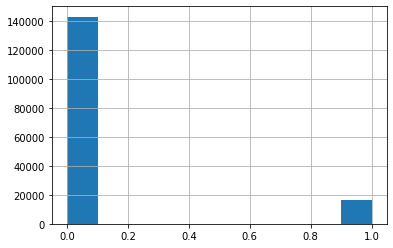

In [33]:
data['toxic'].hist();

Данные имееют дисбаланс.

Проведем лемматизацию текста с помощью WordNetLemmatizer().

In [34]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [35]:
%%time
def clear(text):    
    clear_text = re.sub(r'[^a-zA-z]', ' ', text).lower().split()
    lemm_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in clear_text])  
    return lemm_text 

data['text'] = data['text'].apply(clear)

CPU times: user 15min 32s, sys: 1min 21s, total: 16min 53s
Wall time: 16min 53s


In [36]:
data.head()

,text,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


Разобьем датасет на обучающую и тестовую выборку.

In [37]:
features_train, features_test, target_train, target_test = train_test_split(
    data['text'], 
    data['toxic'], 
    test_size=0.25, 
    stratify=data['toxic'],
    random_state=13)
print(features_train.shape)
print(features_test.shape)

(119469,)
(39823,)


Вывод:

- Были выгружены данные. Датасет имеет два столбца: столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак. 
- Пропусков, дубликатов, аномалий и выбросов выявлено не было, но был выявлен дисбаланс целевого признака. 
- Была проведена лемматизация текста, текст был предварительно очищен. 
- Данные были разделены на обучающую и тестовую выборки.

## Обучение

Выгрузим стоп-слова.

In [38]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Для борьбы с дисбалансом был применен SMOTE(), но это привело к ухудшению метрики и увеличению время расчета.

Обучим модель LogisticRegression() с перебором параметров solver, C, max_iter с применением GridSearchCV().

In [39]:
%%time
pipeline = make_pipeline(TfidfVectorizer(stop_words=list(stopwords)),
                         LogisticRegression(random_state=13))
params = {
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
    'C' : [10],
    'max_iter' : [500]}

new_params = {'logisticregression__' + key: params[key] for key in params}
grid_imba_lr = GridSearchCV(pipeline, 
                             param_grid=new_params,
                             verbose=1,
                             cv=3, 
                             scoring='f1', 
                             n_jobs=-1)
grid_imba_lr.fit(features_train, target_train)
print(grid_imba_lr.best_params_)
print(grid_imba_lr.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'logisticregression__C': 10, 'logisticregression__max_iter': 500, 'logisticregression__solver': 'lbfgs'}
0.766652024618435
CPU times: user 5min 10s, sys: 3min 49s, total: 8min 59s
Wall time: 9min


Для LogisticRegression() была получена лучшая метрика f1 равная 0.767 при параметрах С=10, max_iter=500, solver=lbfgs.

Обучим модель RandomForestClassifier() с перебором параметров n_estimators, max_depth с применением GridSearchCV().

In [40]:
%%time
pipeline = make_pipeline(TfidfVectorizer(stop_words=list(stopwords)),
                         RandomForestClassifier(random_state=13))
params = {
    'n_estimators': [10,30,50],
    'max_depth': [None] + [i for i in range(2,6,2)],
    }
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_imba_rfc = GridSearchCV(pipeline, 
                             param_grid=new_params,
                             verbose=1,
                             cv=3, 
                             scoring='f1', 
                             n_jobs=-1)
grid_imba_rfc.fit(features_train, target_train)
print(grid_imba_rfc.best_params_)
print(grid_imba_rfc.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 50}
0.6856392293289014
CPU times: user 18min 19s, sys: 3.17 s, total: 18min 22s
Wall time: 18min 22s


Для RandomForestClassifier() была получена лучшая метрика f1 равная 0.687 при параметрах max_depth=None, n_estimators=50.

Обучим модель CatBoostClassifier() с перебором параметров n_estimators, learning_rate, depth с применением GridSearchCV().

In [41]:
%%time
pipeline = make_pipeline(TfidfVectorizer(stop_words=list(stopwords)),
                         CatBoostClassifier(random_state=13))
params = {'depth'         : [2,4],
          'learning_rate' : [0.01,0.1],
          'n_estimators'    : [500]
         }
new_params = {'catboostclassifier__' + key: params[key] for key in params}
grid_imba_cbc = GridSearchCV(pipeline, 
                             param_grid=new_params,
                             cv=3, 
                             scoring='f1',
                             verbose=1,
                             n_jobs=-1)
grid_imba_cbc.fit(features_train, target_train)
print(grid_imba_cbc.best_params_)
print(grid_imba_cbc.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
0:	learn: 0.6826601	total: 497ms	remaining: 4m 7s
1:	learn: 0.6723714	total: 921ms	remaining: 3m 49s
2:	learn: 0.6623356	total: 1.35s	remaining: 3m 43s
3:	learn: 0.6526072	total: 1.78s	remaining: 3m 40s
4:	learn: 0.6430582	total: 2.2s	remaining: 3m 38s
5:	learn: 0.6339071	total: 2.63s	remaining: 3m 36s
6:	learn: 0.6248171	total: 3.07s	remaining: 3m 36s
7:	learn: 0.6157550	total: 3.51s	remaining: 3m 35s
8:	learn: 0.6072221	total: 3.95s	remaining: 3m 35s
9:	learn: 0.5990332	total: 4.37s	remaining: 3m 34s
10:	learn: 0.5906606	total: 4.82s	remaining: 3m 34s
11:	learn: 0.5828283	total: 5.24s	remaining: 3m 33s
12:	learn: 0.5752843	total: 5.67s	remaining: 3m 32s
13:	learn: 0.5677609	total: 6.11s	remaining: 3m 31s
14:	learn: 0.5601465	total: 6.55s	remaining: 3m 31s
15:	learn: 0.5528412	total: 6.97s	remaining: 3m 30s
16:	learn: 0.5457874	total: 7.41s	remaining: 3m 30s
17:	learn: 0.5389808	total: 7.85s	remaining: 3m 30s
18:	learn: 0.532

Для CatBoostClassifier() была получена лучшая метрика f1 равная 0.719 при параметрах depth=5, learning_rate=0.1, n_estimators=500.

Проверим метрику на тестовой выборке.

In [42]:
predictions = grid_imba_lr.predict(features_test)
f1 = f1_score(target_test, predictions)
f1

0.7704398180063421

Для лучшей модели была получена на тестовой выборке метрика f1 равная 0.770, что удовлетворяет условиям заказчика.

Вывод:

Были обучены модели LogisticRegression(), RandomForestClassifier() и CatBoostClassifier() при использования поиска по сетке при помощи GridSearchCV().

- Для LogisticRegression() была получена лучшая метрика f1 равная 0.767 при параметрах С=10, max_iter=500, solver=lbfgs.
- Для RandomForestClassifier() была получена лучшая метрика f1 равная 0.687 при параметрах max_depth=None, n_estimators=50.
- Для CatBoostClassifier() была получена лучшая метрика f1 равная 0.719 при параметрах depth=5, learning_rate=0.1, n_estimators=500.

Наилучшей является модель LogisticRegression() при параметрах С=10, max_iter=500, solver=lbfgs.

Для лучшей модели была получена на тестовой выборке метрика f1 равная 0.770, что удовлетворяет условиям заказчика.

## Выводы

**Проект для «Викишоп»**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Мне необходимо было обучить модель классифицировать комментарии на позитивные и негативные. 

**Подготовка** 

- Были выгружены данные. Датасет имеет два столбца: столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак. 
- Пропусков, дубликатов, аномалий и выбросов выявлено не было, но был выявлен дисбаланс целевого признака. 
- Была проведена лемматизация текста, текст был предварительно очищен. 
- Данные были разделены на обучающую и тестовую выборки.

**Обучение**

Были обучены модели LogisticRegression(), RandomForestClassifier() и CatBoostClassifier() при использования поиска по сетке при помощи GridSearchCV().

- Для LogisticRegression() была получена лучшая метрика f1 равная 0.767 при параметрах С=10, max_iter=500, solver=lbfgs.
- Для RandomForestClassifier() была получена лучшая метрика f1 равная 0.687 при параметрах max_depth=None, n_estimators=50.
- Для CatBoostClassifier() была получена лучшая метрика f1 равная 0.719 при параметрах depth=5, learning_rate=0.1, n_estimators=500.

Наилучшей является модель LogisticRegression() при параметрах С=10, max_iter=500, solver=lbfgs.

Для лучшей модели была получена на тестовой выборке метрика f1 равная 0.770, что удовлетворяет условиям заказчика.